# Admin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit

import importlib

import Calibration_Function_V2 as CF2

importlib.reload(CF2)


<module 'Calibration_Function_V2' from 'C:\\Users\\sebas\\PycharmProjects\\Advanced-Lab-Code\\Monochromator_Calibration\\Calibration_Function_V2.py'>

In [2]:
# Data Processing
wavelengths = np.array([632.8,  #Red
               594.1,  #Orange
               543.5,  #Green
               ])

start_indexes = [6980,  #Red
                 6935,  #Orange
                 6890,  #Green
                 ]

sheets = ['Red',
          'Orange',
          'Green'
          ]

cols = [
    ['R_A_0', 'R_A_1', 'R_A_2', 'R_A_3', 'R_A_4', 'R_A_5', 'R_A_6', 'R_A_7', 'R_A_8', 'R_A_9'],  #Red
    ['O_A_0', 'O_A_1', 'O_A_2', 'O_A_3', 'O_A_4', 'O_A_5', 'O_A_6', 'O_A_7', 'O_A_8', 'O_A_9'],  # Orange
    ['G_A_0', 'G_A_1', 'G_A_2', 'G_A_3', 'G_A_4']  #Green
]
file = "Calibration_Runs.xlsx"

In [3]:
def chi_squared(model, model_params, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params)) / y_error)**2)

def reduced_chi_squared(Chi_squared, DoF):
    return Chi_squared / (DoF)

# Peak Extraction

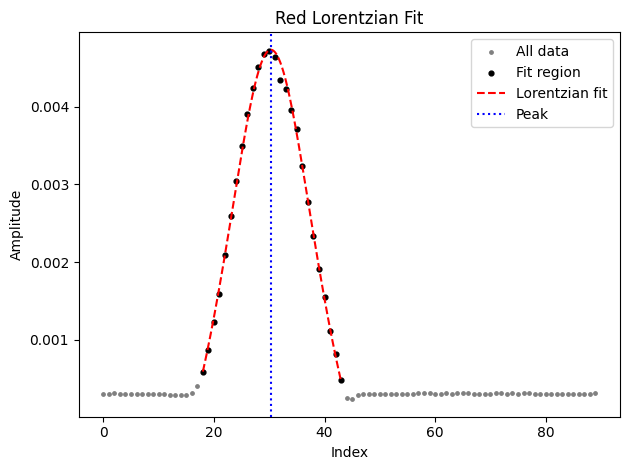

 ---- Results ---- 
Sheet: Red
Peak index = 30.302 ± 0.431
Width B = 11.79
Reduced χ² = 0.006
Amplitude cutoff = 10.0% of A_max
----- ----- -----



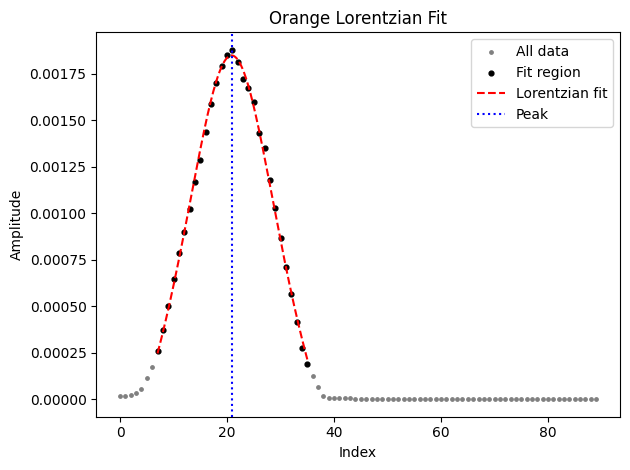

 ---- Results ---- 
Sheet: Orange
Peak index = 20.851 ± 0.408
Width B = 13.12
Reduced χ² = 0.017
Amplitude cutoff = 10.0% of A_max
----- ----- -----



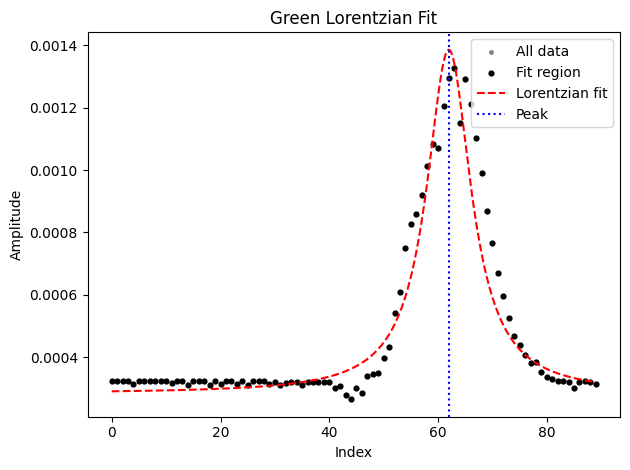

 ---- Results ---- 
Sheet: Green
Peak index = 61.971 ± 1.221
Width B = 5.00
Reduced χ² = 0.041
Amplitude cutoff = 10.0% of A_max
----- ----- -----



In [4]:
results, res_err = CF2.peak_extractor(
    file = file,
    sheets = sheets,
    cols = cols,
    amplitude_frac= 0.1,
    uncertainty_frac= 1e-3,
    min_points= 15,
    min_width= 5,
    max_width= 300
)

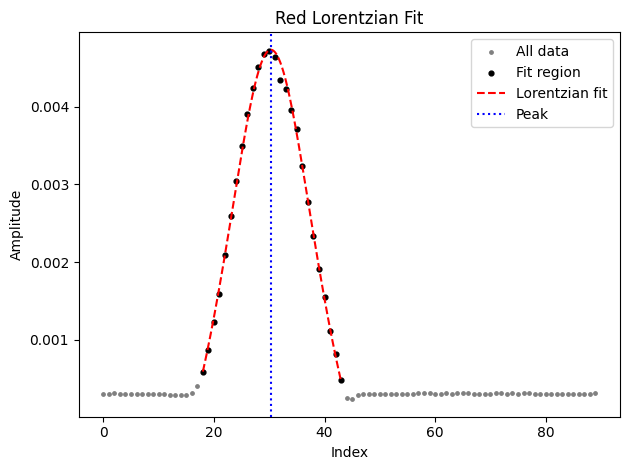

 ---- Results ---- 
Sheet: Red
Peak index = 30.302 ± 0.431
Width B = 11.79
Reduced χ² = 0.006
Amplitude cutoff = 10.0% of A_max
----- ----- -----



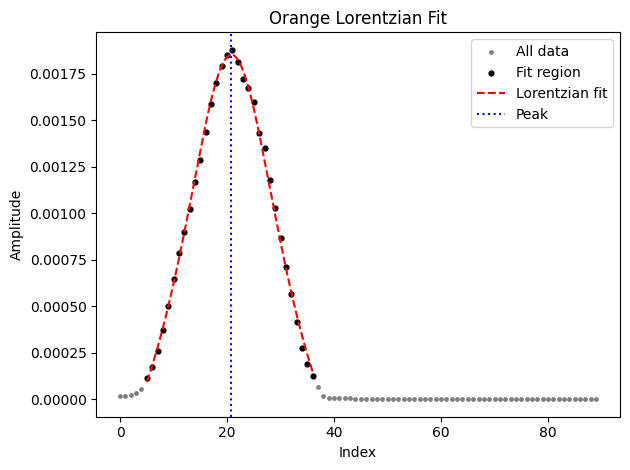

 ---- Results ---- 
Sheet: Orange
Peak index = 20.816 ± 0.380
Width B = 12.35
Reduced χ² = 0.021
Amplitude cutoff = 5.0% of A_max
----- ----- -----



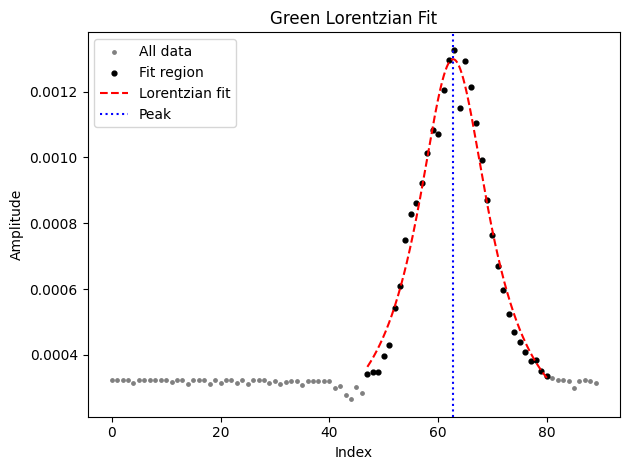

 ---- Results ---- 
Sheet: Green
Peak index = 62.764 ± 1.299
Width B = 8.16
Reduced χ² = 0.019
Amplitude cutoff = 25.0% of A_max
----- ----- -----



In [82]:
results_red, red_err = CF2.peak_extractor(
    file = file,
    sheets = sheets[0],
    cols = cols[0],
    amplitude_frac= 0.1,
    uncertainty_frac= 1e-3,
    min_points= 15,
    min_width= 5,
    max_width= 300
)

results_orange, orange_err  = CF2.peak_extractor(
    file = file,
    sheets = sheets[1],
    cols = cols[1],
    amplitude_frac= 0.05,
    uncertainty_frac= 1e-3,
    min_points= 15,
    min_width= 5,
    max_width= 300
)

results_green, green_err = CF2.peak_extractor(
    file = file,
    sheets = sheets[2],
    cols = cols[2],
    amplitude_frac= 0.25,
    uncertainty_frac= 1e-3,
    min_points= 15,
    min_width= 5,
    max_width= 300
)

# Line Fitting

In [89]:
results = np.concatenate((results_red, results_orange, results_green))
results_err = np.concatenate((red_err, orange_err, green_err))

def line(x, A, B):
    return x*A +B

p0_line = [1,1]

indexes = start_indexes - 0.1* results
indexes_error = np.abs((start_indexes - 0.1* (results+ results_err)) - (start_indexes - 0.1* results))

print(results_err)
print(indexes_error)

popt_line, cov_line = curve_fit(line,
                                xdata= wavelengths,
                                ydata= indexes,
                                sigma= indexes_error,
                                absolute_sigma= True,
                                p0= p0_line)

dof_line = len(wavelengths) - len(popt_line)

chi2 = chi_squared(model= line,
                   model_params=popt_line,
                   x_data= wavelengths,
                   y_data= indexes,
                   y_error= indexes_error
                   )

Rchi2 = reduced_chi_squared(chi2, DoF = dof_line)

[0.43079407 0.38002052 1.29926247]
[0.04307941 0.03800205 0.12992625]


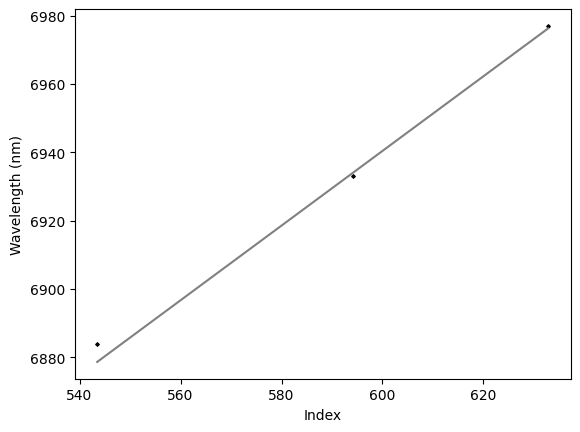

----- Results -----
Gradient is 1.0932 ± 0.0012
Intercept is 6284.4508 ± 0.7212
Reduced chi_squared is 2544.6798
----- ----- -----


In [91]:
plt.figure(1)

plt.scatter(wavelengths, indexes, marker= "D", color = 'black', s = 3)
plt.plot(wavelengths, line(wavelengths, popt_line[0], popt_line[1]), color = "grey")

plt.xlabel("Index")
plt.ylabel("Wavelength (nm)")
plt.show()

print(f"----- Results -----")
print(f"Gradient is {popt_line[0]:.4f} ± {np.sqrt(cov_line[0,0]):.4f}")
print(f"Intercept is {popt_line[1]:.4f} ± {np.sqrt(cov_line[1,1]):.4f}")
print(f"Reduced chi_squared is {Rchi2:.4f}")
print("----- ----- -----")